**<center><font size=5>EEG Data Analysis</font></center>**
***<center>Alcoholic vs Control Groups</center>***
***
**author**: Ruslan Klymentiev

**current co-author & modificator**: Ilya Kotlov

**date**: 5th January, 2019

**[GitHub Repository](https://github.com/ruslan-kl/EEG-data-analysis)**

#### Table of Contents
- <a href='#intro'>1. Project Overview</a> 
- <a href='#env'>2. Setting up the Environment</a>
 - <a href='#import'>2.1. Data Import</a>
 - <a href='#var_des'>2.2. Variables description</a>
- <a href='#sample'>3. Data Sample Visualization</a> 
 - <a href='#s1'>3.1. Data Sample for "S1 obj" Stimulus</a>
 - <a href='#s2m'>3.2. Data Sample for "S2 match" Stimulus</a>
 - <a href='#s2nm'>3.3. Data Sample for "S2 nomatch" Stimulus</a>
 - <a href='#corr_sample'>3.4. Correlations between the Regions</a>
- <a href='#whole_set'>4. Whole EEG Data Set Analysis</a> 
 - <a href='#corr'>4.1. Correlations between the Regions</a>
 - <a href='#avg_comp'>4.2. Compare the Average Response Values</a>
- <a href='#conclusion'>5. Conclusions</a> 

# <a id='intro'>1. Project Overview</a>

It's been a while since a posted something on Kaggle, so I thought that it is time to change it. I have chosen the [EEG-Alcohol](https://www.kaggle.com/nnair25/Alcoholics) dataset, which contains [EEG (Electroencephalography)](https://en.wikipedia.org/wiki/Electroencephalography) data for two groups - Alcoholic and Control Group. 
![](https://i.imgur.com/ZrmxJRu.jpg)
Amount of subjects in each group is 8. The 64 electrodes were placed on subject's scalps to measure theelectrical activity of the brain. The response values were sampled at 256 Hz (3.9-msec epoch) for 1 second. Each subject was exposed to either a single stimulus (S1) or to two stimuli (S1 and S2) which were pictures of objects chosen from the [1980 Snodgrass and Vanderwart picture set](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.294.1979&rep=rep1&type=pdf). When two stimuli were shown, they were presented in either a matched condition where S1 was identical to S2 or in a non-matched condition where S1 differed from S2.

The purpose of my analysis is going to be to find out if there is a difference in response values for different stimuli between control and alcoholic group. And if so, in what brain regions this happens? 

# <a id='env'>2. Setting up the Environment</a>
## <a id='import'>2.1. Data Import</a>

In [137]:
import gdown
url = 'https://drive.google.com/drive/folders/1c4lrCmQplXhmzBqpGwlIr1-eEN5j_ykH'
output = './'
gdown.download_folder(url=url,output=output, quiet=False)

Retrieving folder list


Processing file 1x3aa41vprwILnE2Tr8YcPMA8RkxpEQq_ EEG_dataset.zip
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1x3aa41vprwILnE2Tr8YcPMA8RkxpEQq_
To: F:\GithubRep\Data-Science-for-NeuroScience\EEG_dataset.zip
100%|███████████████████████████████████████████████████████████████████████████████| 293M/293M [03:46<00:00, 1.29MB/s]
Download completed


['./EEG_dataset.zip']

In [138]:
import zipfile
path_to_zip_file = output + '/EEG_dataset.zip'
folder_name = 'EEG_dataset'
directory_to_extract_to = output
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [139]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu

init_notebook_mode(connected=True) ## plotly init
seed = 123
random.seed = seed

folder_name = 'EEG_dataset'

In [140]:
cur_dir = os.getcwd()
train_path = cur_dir+'/'+folder_name+'/SMNI_CMI_TRAIN/'
test_path = cur_dir+'/'+folder_name+'/SMNI_CMI_TEST/'
print('Total amount of files in SMNI_CMI_TRAIN directory: ' + str(len(train_path)))

Total amount of files in SMNI_CMI_TRAIN directory: 70


In [147]:
filenames_list = os.listdir(train_path) ## list of file names in the directory
EEG_data = pd.DataFrame({}) ## create an empty df that will hold data from each file

for file_name in tqdm(filenames_list):
    temp_df = pd.read_csv(train_path + file_name) ## read from the file to df
    EEG_data = EEG_data.append(temp_df) ## add the file data to the main df

100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [09:14<00:00,  1.19s/it]


In [148]:
EEG_data = EEG_data.drop(['Unnamed: 0'], axis=1) ## remove the unused column
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' ## remove comma sign from stimulus name

In [149]:
## here is how the data looks like
EEG_data.head()

,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,0,FP1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000
1,0,FP1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906
2,0,FP1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812
3,0,FP1,3,5.239,a,S1 obj,0,co2a0000364,0.011719
4,0,FP1,4,11.587,a,S1 obj,0,co2a0000364,0.015625


## <a id='var_des'>2.2. Variables description</a>

* `trial number`: number of the trial (obviously) 
* `sensor postition`:  position of electrode placed on subject's scalp (based on International 10-20 system)
<img src="https://i.ibb.co/M2GRQNz/670px-International-10-20-system-for-EEG-MCN-svg.png" alt="670px-International-10-20-system-for-EEG-MCN-svg" border="0">
![](imgs/eeg10-20.PNG)
* `sample num`: 0-255
* `sensor value`: value in microvolts 
* `subject identifier`: `a` - Alcoholic; `c` - Control
* `matching condition`: 
 * `S1 obj` - a single object shown; 
 * `S2 match` - object 2 shown in a matching condition (S1 was identical to S2), 
 * `S2 nomatch` - object 2 shown in a non matching condition (S1 differed from S2)
* `channel`: channel number (0-63). Basically, it's the same as `sensor position` column, so one of these columns can be dropped
* `name`: a serial code assigned to each subject
* `time`: inverse of `sample num` measured in seconds

for more information on thye data see: https://archive.ics.uci.edu/ml/datasets/eeg+database

I have changed some `sensor position`s so they match the basics for head topography visualization. Also, I have removed those positions which equal to **X**, **Y** and **ND** since I couldnt figure out which regions they respond to.

In [150]:
## replace some 'sensor position' values
EEG_data.loc[EEG_data['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data.loc[EEG_data['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data.loc[EEG_data['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data.loc[EEG_data['sensor position'] == 'PO2', 'sensor position'] = 'PO4'
## remove rows with undefined positions
EEG_data = EEG_data[(EEG_data['sensor position'] != 'X') & (EEG_data['sensor position'] != 'Y') & (EEG_data['sensor position'] != 'nd')]

# <a id='sample'>3. Data Sample Visualization</a> 

In this section I will randomly choose a subject from each group and plot the 3-D surface and heatmaps of response values to visually inspect the difference among groups.

In [151]:
def sample_data(stimulus, random_id=random.randint(0,7)):
    """Function merged data frame - one data frame for randomly selected subject from control group and 
    one data frame for randomly selected subject from alcoholic group"""
    ## random choose the name_id of subject from alcoholic/control group
    alcoholic_id = EEG_data['name'][(EEG_data['subject identifier'] == 'a') & 
                                    (EEG_data['matching condition'] == stimulus)].unique()[random_id]
    control_id = EEG_data['name'][(EEG_data['subject identifier'] == 'c') & 
                                  (EEG_data['matching condition'] == stimulus)].unique()[random_id]
    
    ## get min trial numbers for each group
    alcoholic_trial_number = EEG_data['trial number'][(EEG_data['name'] == alcoholic_id) & (EEG_data['matching condition'] == stimulus)].min()
    control_trial_number = EEG_data['trial number'][(EEG_data['name'] == control_id) & (EEG_data['matching condition'] == stimulus)].min()

    ## filter the EEG DF
    alcoholic_df = EEG_data[(EEG_data['name'] == alcoholic_id) & (EEG_data['trial number'] == alcoholic_trial_number)]
    control_df = EEG_data[(EEG_data['name'] == control_id) & (EEG_data['trial number'] == control_trial_number)]
    
    return alcoholic_df.append(control_df)

In [152]:
sensor_positions = EEG_data[['sensor position', 'channel']].drop_duplicates().reset_index(drop=True).drop(['channel'], axis=1).reset_index(drop=False).rename(columns={'index':'channel'})['sensor position']
channels = EEG_data[['sensor position', 'channel']].drop_duplicates().reset_index(drop=True).drop(['channel'], axis=1).reset_index(drop=False).rename(columns={'index':'channel'})['channel']

In [153]:
def plot_3dSurface_and_heatmap(stimulus, group, df):
    
    if group == 'c':
        group_name = 'Control'
    else:
        group_name = 'Alcoholic'
        
    temp_df = pd.pivot_table(
            df[['channel', 'sample num', 'sensor value']] \
            [(df['subject identifier'] == group) & 
             (df['matching condition'] == stimulus)],
            index='channel', columns='sample num', values='sensor value').values.tolist()
    
    data = [go.Surface(z=temp_df, colorscale='Bluered')]

    layout = go.Layout(
        title='<br>3d Surface and Heatmap of Sensor Values for ' + stimulus + ' Stimulus for ' + group_name + ' Group',
        width=800,
        height=900,
        autosize=False,
        margin=dict(t=0, b=0, l=0, r=0),
        scene=dict(
            xaxis=dict(
                title='Time (sample num)',
                gridcolor='rgb(255, 255, 255)',
    #             erolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)'
            ),
            yaxis=dict(
                title='Channel',
                tickvals=channels,
                ticktext=sensor_positions,
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230, 230)'
            ),
            zaxis=dict(
                title='Sensor Value',
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)'
            ),
            aspectratio = dict(x=1, y=1, z=0.5),
            aspectmode = 'manual'
        )
    )

    updatemenus=list([
        dict(
            buttons=list([   
                dict(
                    args=['type', 'surface'],
                    label='3D Surface',
                    method='restyle'
                ),
                dict(
                    args=['type', 'heatmap'],
                    label='Heatmap',
                    method='restyle'
                )             
            ]),
            direction = 'left',
            pad = {'r': 10, 't': 10},
            showactive = True,
            type = 'buttons',
            x = 0.1,
            xanchor = 'left',
            y = 1.1,
            yanchor = 'top' 
        ),
    ])

    annotations = list([
        dict(text='Trace type:', x=0, y=1.085, yref='paper', align='left', showarrow=False)
    ])
    layout['updatemenus'] = updatemenus
    layout['annotations'] = annotations

    fig = dict(data=data, layout=layout)
    iplot(fig)

## <a id='s1'>3.1. Data Sample for "S1 obj" Stimulus</a>

In [154]:
stimulus = 'S1 obj'
S1_sample_df = sample_data(stimulus=stimulus, random_id=1)

In [155]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='a', df=S1_sample_df)

In [156]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='c', df=S1_sample_df)

## <a id='s2m'>3.2. Data Sample for "S2 match" Stimulus</a>

In [157]:
stimulus = 'S2 match'
S2_m_sample_df = sample_data(stimulus=stimulus, random_id=1)

In [158]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='a', df=S2_m_sample_df)

In [159]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='c', df=S2_m_sample_df)

Some big spike happend here for control subject. High response values (which respond to front right region of the head) could be caused by eye movement or blink.

## <a id='s2nm'>3.3. Data Sample for "S2 nomatch" Stimulus</a>

In [160]:
stimulus = 'S2 nomatch'
S2_nm_sample_df = sample_data(stimulus=stimulus, random_id=1)

In [161]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='a', df=S2_nm_sample_df)

In [162]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='c', df=S2_nm_sample_df)

Let's take a look at EEG topography for the last example (*S2 nomatch stimulus*) to see how brain regions are differ. I have found a terrific work of **Matt Craddock** at his [website blog](https://www.mattcraddock.com/blog/2017/02/25/erp-visualization-creating-topographical-scalp-maps-part-1/) on how to create EEG topography using R. I created sample topography plots and converted them into .gif animations, so here are the final result. You can see my implementation of Matt's code at [GitHub](https://github.com/ruslan-kl/EEG-data-analysis/blob/master/plot_topography.R).

| **Alcoholic** | **Control** |
|--|--|
| <img src="https://i.ibb.co/kBmwypK/s2-nm-a.gif" alt="s2-nm-a" border="0"> | <img src="https://i.ibb.co/R9SQG0j/s2-nm-c.gif" alt="s2-nm-c" border="0"> |

After the quick glimpse it looks like on average response values are higher for alcoholic group. 

## <a id='corr_sample'>3.4. Correlations between the Regions</a>

Next step will be to investigate the correlations between firing rates of each sensor position. If two brain regions have high correlation value that means that they trend to wire together.

In [163]:
## create the list of possible channel pairs
sample_corr_df = pd.pivot_table(S2_nm_sample_df[S2_nm_sample_df['subject identifier'] == 'a'], values='sensor value', index='sample num', columns='sensor position').corr()

list_of_pairs = []
j = 0
for column in sample_corr_df.columns:
    j += 1
    for i in range(j, len(sample_corr_df)):
        if column != sample_corr_df.index[i]:
            temp_pair = [column + '-' + sample_corr_df.index[i]]
            list_of_pairs.append(temp_pair)

In [164]:
def get_correlated_pairs_sample(threshold, correlation_df, group):
    ## create dictionary wheke keys are the pairs and values are the amount of high correlation pair
    corr_pairs_dict = {}
    for i in range(len(list_of_pairs)):
        temp_corr_pair = dict(zip(list_of_pairs[i], [0]))
        corr_pairs_dict.update(temp_corr_pair)

    j = 0
    for column in correlation_df.columns:
        j += 1
        for i in range(j, len(correlation_df)):
            if ((correlation_df[column][i] >= threshold) & (column != correlation_df.index[i])):
                corr_pairs_dict[column + '-' + correlation_df.index[i]] += 1

    corr_count = pd.DataFrame(corr_pairs_dict, index=['count']).T.reset_index(drop=False).rename(columns={'index': 'channel_pair'})
    print('Channel pairs that have correlation value >= ' + str(threshold) + ' (' + group + ' group):')
    print(corr_count['channel_pair'][corr_count['count'] > 0].tolist())

In [165]:
def plot_sensors_correlation(df, threshold_value):
    """Funtion plots the the correlation plots between sensor positions for each group"""
    correlations_alcoholic = pd.pivot_table(df[df['subject identifier'] == 'a'], 
                                          values='sensor value', index='sample num', columns='sensor position').corr()

    correlations_control = pd.pivot_table(df[df['subject identifier'] == 'c'], 
                                          values='sensor value', index='sample num', columns='sensor position').corr()

    fig = plt.figure(figsize=(17,10))
    ax = fig.add_subplot(121)
    ax.set_title('Alcoholic group', fontsize=14)
    mask = np.zeros_like(correlations_alcoholic, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlations_alcoholic, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    ax = fig.add_subplot(122)
    ax.set_title('Control group', fontsize=14)
    mask = np.zeros_like(correlations_control, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlations_control, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.suptitle('Correlation between Sensor Positions for ' + df['matching condition'].unique()[0] + ' stimulus', fontsize=16)
    plt.show()
    
    get_correlated_pairs_sample(threshold=threshold_value, correlation_df=correlations_alcoholic, group='Alcoholic')
    print('\n')
    get_correlated_pairs_sample(threshold=threshold_value, correlation_df=correlations_control, group='Control')

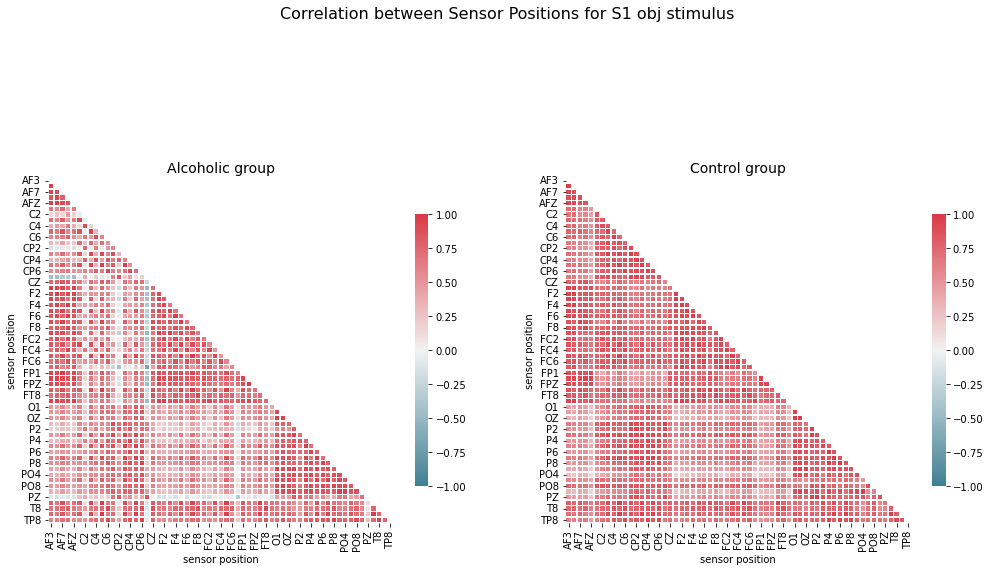

Channel pairs that have correlation value >= 0.97 (Alcoholic group):
['AF3-AFZ', 'AF3-F1', 'AF4-AFZ', 'AF7-FP1', 'AF8-F4', 'AF8-F6', 'AFZ-F1', 'C5-CP5', 'C5-FC5', 'C5-FT7', 'C5-T7', 'C5-TP7', 'CP3-CP5', 'CP3-P5', 'CP5-TP7', 'F1-FC1', 'F3-FC1', 'F4-F6', 'F5-F7', 'F5-FC5', 'F7-FC5', 'F7-FT7', 'FC5-FT7', 'FC5-T7', 'FP2-FPZ', 'FT7-T7', 'O1-OZ', 'P3-P5', 'P5-P7', 'PO3-POZ', 'T7-TP7']


Channel pairs that have correlation value >= 0.97 (Control group):
['AF3-AF4', 'C5-T7', 'CP1-CP3', 'CP5-TP7', 'F1-F3', 'F1-FZ', 'F2-F4', 'F2-FZ', 'F3-F5', 'F6-F8', 'FC2-FCZ', 'O1-O2', 'O1-OZ', 'O2-OZ', 'P1-P3', 'P2-PZ', 'P4-P6', 'P4-P8', 'P5-P7', 'P6-P8', 'PO4-POZ', 'T7-TP7']


In [166]:
plot_sensors_correlation(df=S1_sample_df, threshold_value=.97)

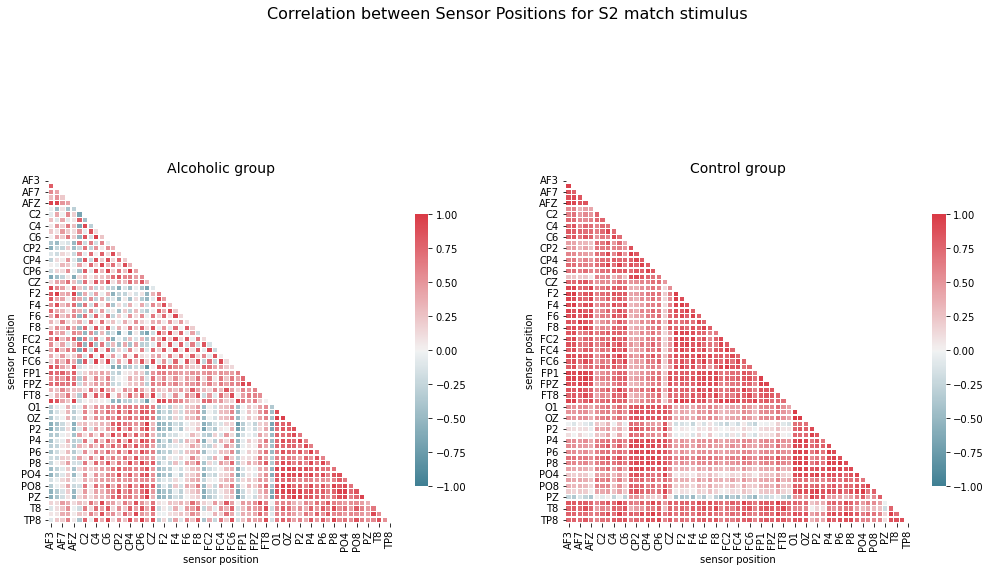

Channel pairs that have correlation value >= 0.97 (Alcoholic group):
['AF4-F2', 'CP4-CP6', 'CP6-TP8', 'O1-OZ', 'P1-PZ']


Channel pairs that have correlation value >= 0.97 (Control group):
['AF4-F2', 'AF8-F8', 'AF8-FP2', 'C5-T7', 'CP3-P5', 'CP5-TP7', 'F1-F3', 'F1-FZ', 'F2-F4', 'F2-FZ', 'FT7-T7', 'O1-O2', 'O1-OZ', 'O2-OZ', 'P4-P6', 'P4-P8', 'P6-P8', 'P7-TP7', 'PO4-POZ']


In [167]:
plot_sensors_correlation(df=S2_m_sample_df, threshold_value=.97)

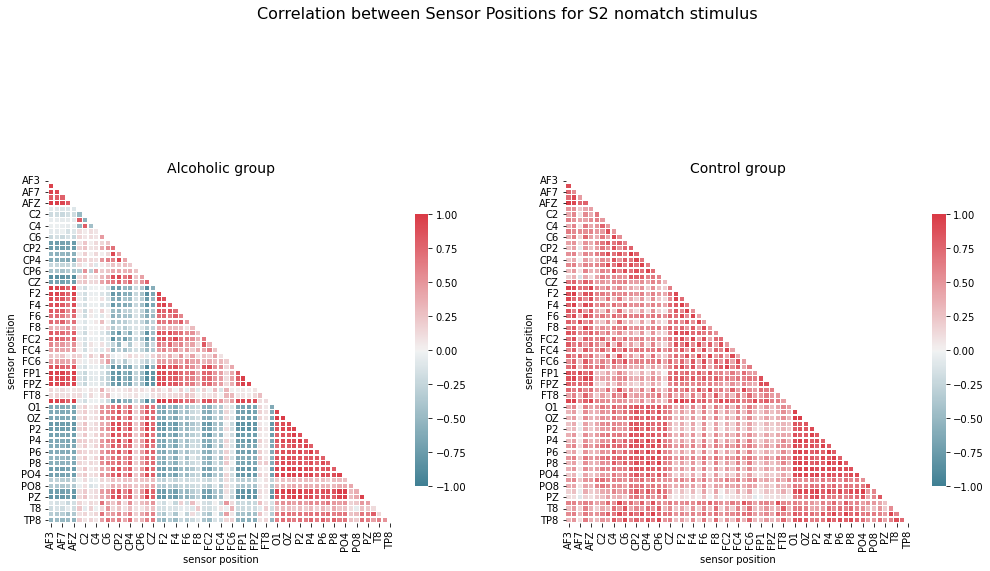

Channel pairs that have correlation value >= 0.97 (Alcoholic group):
['AF3-AFZ', 'AF3-F1', 'AF3-FP1', 'AF3-FZ', 'AF4-AFZ', 'AFZ-FP1', 'AFZ-FZ', 'F1-FZ', 'F2-FZ', 'FP1-FP2', 'FP1-FPZ', 'O1-OZ', 'O2-OZ', 'OZ-POZ', 'P2-P4', 'P2-PO4', 'P2-POZ', 'P2-PZ', 'P4-P6', 'PO3-POZ', 'PO4-POZ']


Channel pairs that have correlation value >= 0.97 (Control group):
['AF3-AFZ', 'CP1-CP3', 'O1-OZ', 'O2-OZ', 'P4-P6', 'P4-P8', 'P5-P7', 'P6-P8', 'PO4-POZ']


In [168]:
plot_sensors_correlation(df=S2_nm_sample_df, threshold_value=.97)

**What can we learn from these correlated pairs?**

First of all, there were no surprises - high correlation appears between regions that are close to each other. Maybe we will see some unsurprised pairs when looking on the full data.

Secondly, you can notice the interesting trend that some regions of the brain show different correlation values among subjects (like [O1-PZ] vs [F2-FT8]). When correlations are high for alcoholic subject they are low for control subject and vice versa. Let's look back on *S1 obj* stimuli as an example:
<img src="https://i.ibb.co/h1ty8fq/Deepin-Screenshot-select-area-20181228000405.png" alt="Deepin-Screenshot-select-area-20181228000405" border="0">
**P** stands for Parietal, **O** - Occipital (which both are closer to the back of the head), **F** - Frontal, **C** - Central parts of the brain. 

For alcoholic subject the higher the values in **P** and **O** regions, the lower are the values in **F** and **C** regions (and vice versa). But for the control subject the correlation for this regions is positive (the higher the one, the higher the other). And for each stimulus the picture is all the way around.

# <a id='whole_set'>4. Whole EEG Data Set Analysis</a>

For now we've been looking on example of one subject from each group. Now we will see how does the picture changes when we apply the same analysis of the whole data set. Let's start on finding the correlation pairs for each trial.

## <a id='corr'>4.1. Correlations between the Regions</a>

What exactly I am going to do is to find top 20 correlated pairs for each stimuli among two groups and plot them together to see if these pairs are different.

In [169]:
def get_correlated_pairs(stimulus, threshold, group):
    """Funtion returns the df which holds pairs of channel with high correlation for stimulus, group and threshold provided"""
    corr_pairs_dict = {}
    trial_numbers_list = EEG_data['trial number'][(EEG_data['subject identifier'] == group) & (EEG_data['matching condition'] == stimulus)].unique()
    ## create dictionary wheke keys are the pairs and values are the amount of high correlation pair
    for i in range(len(list_of_pairs)):
        temp_corr_pair = dict(zip(list_of_pairs[i], [0]))
        corr_pairs_dict.update(temp_corr_pair)

    for trial_number in trial_numbers_list:    
        correlation_df = pd.pivot_table(EEG_data[(EEG_data['subject identifier'] == group) & (EEG_data['trial number'] == trial_number)], 
                                        values='sensor value', index='sample num', columns='sensor position').corr()

        j = 0 ## by setting the j we are going just through values below the main diagonal
        for column in correlation_df.columns:
            j += 1
            for i in range(j, len(correlation_df)):
                if ((correlation_df[column][i] >= threshold) & (column != correlation_df.index[i])):
                    corr_pairs_dict[column + '-' + correlation_df.index[i]] += 1

    corr_count = pd.DataFrame(corr_pairs_dict, index=['count']).T.reset_index(drop=False).rename(columns={'index': 'channel_pair'})
    corr_count['group'] = group
    corr_count['stimulus'] = stimulus
    return(corr_count)

In [170]:
corr_pairs_df = pd.DataFrame({})
stimuli_list = ['S1 obj', 'S2 match', 'S2 nomatch']
## create df that holds information of total trial amount for each subject by stimulus
size_df = EEG_data.groupby(['subject identifier', 'matching condition'])[['trial number']].nunique().reset_index(drop=False).rename(columns={'trial number':'trials_count'})

for stimulus in stimuli_list:
    corr_pairs_df = corr_pairs_df.append(get_correlated_pairs(stimulus=stimulus, threshold=.9, group='c'))
    corr_pairs_df = corr_pairs_df.append(get_correlated_pairs(stimulus=stimulus, threshold=.9, group='a'))
corr_pairs_df = corr_pairs_df.merge(size_df, left_on=['group', 'stimulus'], right_on=['subject identifier', 'matching condition'], how='left')

In [171]:
def compare_corr_pairs(stimulus):
    """Function creates bar chart with the ratio of correlated pairs for both groups"""
    top_control_df = corr_pairs_df[(corr_pairs_df['group'] == 'c') & (corr_pairs_df['stimulus'] == stimulus)]
    top_alcoholic_df = corr_pairs_df[(corr_pairs_df['group'] == 'a') & (corr_pairs_df['stimulus'] == stimulus)]
    top_control_pairs = top_control_df.sort_values('count', ascending=False)['channel_pair'][:20]
    top_alcoholic_pairs = top_alcoholic_df.sort_values('count', ascending=False)['channel_pair'][:20]

    merged_df = pd.DataFrame({'channel_pair': top_control_pairs.append(top_alcoholic_pairs).unique()})
    merged_df = merged_df.merge(top_control_df[['channel_pair', 'count', 'trials_count']],
                               on='channel_pair', how='left').rename(columns={'count':'count_control', 'trials_count': 'trials_count_c'})
    merged_df = merged_df.merge(top_alcoholic_df[['channel_pair', 'count', 'trials_count']],
                               on='channel_pair', how='left').rename(columns={'count':'count_alcoholic', 'trials_count': 'trials_count_a'})
    
    data_1 = go.Bar(x=merged_df['channel_pair'],
                    y=(merged_df['count_alcoholic']/merged_df['trials_count_a']).apply(lambda x: round(x,2)),
                    text=merged_df['count_alcoholic'],
                    name='Alcoholic Group',
                    marker=dict(color='rgb(20,140,45)'))

    data_2 = go.Bar(x=merged_df['channel_pair'],
                    y=(merged_df['count_control']/merged_df['trials_count_c']).apply(lambda x: round(x,2)),
                    text=merged_df['count_control'],
                    name='Control Group',
                    marker=dict(color='rgb(200,100,45)'))

    layout = go.Layout(title='Amount of Correlated Pairs for the whole Data Set (' + stimulus + ' stimulus)',
                       xaxis=dict(title='Channel Pairs'),
                       yaxis=dict(title='Ratio'),
                       barmode='group')

    data = [data_1, data_2]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [172]:
compare_corr_pairs(stimulus='S1 obj')

In [173]:
compare_corr_pairs(stimulus='S2 match')

In [174]:
compare_corr_pairs(stimulus='S2 nomatch')

**What can we see here?**

Again, no surprises, all high correlations are seems to be between regions that are close to each other. 

Some interesting insight: **FP1-FPZ** and **FP1-FP2** pairs showed the high correlation value for control subjects >90% of the time. But for the alcoholic group this ration is much lower (~20%).

## <a id='avg_comp'>4.2. Compare the Average Response Values</a>

Now I am going to check whether the response values among two groups show significantly different result. To do so I will run [Mann–Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test).

* **Null Hypothesis**: No difference for response values for the single channel between Alcoholic and Controls Groups
* **Alternative Hypothesis**: There is a significant difference for response values between Alcoholic and Controls Groups (*two-tailed test*)
* **Significance level $\alpha$** = 0.05

In [175]:
stimulus_list = EEG_data['matching condition'].unique().tolist() ## list of stimuli
channels_list = EEG_data['channel'].unique().tolist() ## list of channels

## get the Average Sensor Values for each channel by Subject group and Stimulus
agg_df = EEG_data.groupby(['subject identifier', 'matching condition', 'sensor position'], as_index=False)[['sensor value']].mean()

In [177]:
def get_p_value(stimulus, sensor):
    """
    Funtion takes the stimulus parameter and channel number and returns the p-value from Mann Whitney U-test (Alcoholic vs Control).
    """
    x = EEG_data[['sensor value']][(EEG_data['subject identifier'] == 'a') & 
                                   (EEG_data['matching condition'] == stimulus) & 
                                   (EEG_data['sensor position'] == sensor)]
    y = EEG_data[['sensor value']][(EEG_data['subject identifier'] == 'c') & 
                                   (EEG_data['matching condition'] == stimulus) & 
                                   (EEG_data['sensor position'] == sensor)]
    stat, p = mannwhitneyu(x=x, 
                           y=y,
                           alternative='two-sided')
    return p

In [178]:
## create empty df that will hold info about the statistica test
stat_test_results = pd.DataFrame({'stimulus': [], 
                                  'sensor': [],
                                  'p_value': []})

for sensor in tqdm(EEG_data['sensor position'].unique()):
    for stimulus in EEG_data['matching condition'].unique():
        temp_df = pd.DataFrame({'stimulus': stimulus,
                                'sensor': sensor,
                                'p_value': get_p_value(stimulus=stimulus, sensor=sensor)},
                               index=[0])
        stat_test_results = stat_test_results.append(temp_df)
        
stat_test_results = stat_test_results.reset_index(drop=True)
stat_test_results['reject_null'] = stat_test_results['p_value'] <= 0.05 ## check whether we can reject null hypothesis

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:48<00:00, 10.64s/it]


Let's look at the ratio of how many responses were significantly different among two groups across all channels.

In [179]:
stat_test_results.groupby(['stimulus'])[['reject_null']].mean()

,reject_null
stimulus,
S1 obj,0.901639
S2 match,0.770492
S2 nomatch,0.803279


Doesn't it looks impressive? 
* ~90% of channels (~55 channels) responed significanlty different when single object was shown;
* ~77% of channels (~47 channels) responed significanlty different when two identical objects were shown;
* ~80% of channels (~50 channels) responed significanlty different when two non-identical objects were shown.

We can take a look at each channel to see which stimuli showed the significant difference among two groups.

In [182]:
stat_test_results

,stimulus,sensor,p_value,reject_null
0,S1 obj,FP1,1.033174e-08,True
1,S2 nomatch,FP1,3.915660e-01,False
2,S2 match,FP1,1.624131e-01,False
3,S1 obj,FP2,1.083366e-06,True
4,S2 nomatch,FP2,3.857129e-12,True
...,...,...,...,...
178,S2 nomatch,P1,3.547270e-15,True
179,S2 match,P1,2.104164e-07,True
180,S1 obj,CPZ,2.368871e-45,True
181,S2 nomatch,CPZ,7.679874e-07,True


In [184]:
data = []
for stimulus in stimulus_list:
    trace = go.Bar(x=stat_test_results['sensor'][stat_test_results['stimulus'] == stimulus],
                    y=stat_test_results['reject_null'][stat_test_results['stimulus'] == stimulus],
                    name=stimulus)
    data.append(trace)

layout = go.Layout(title='Amount of Significant Differences for each Channel',
                   xaxis=dict(title='Sensor Position'),
                   yaxis=dict(title='Is Significant',
                              showticklabels=True),
                   barmode='stack')
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [ ]:
# ## df that will be needed to plot the 'sesnors' that showed the difference for 3 stimuli in different color on ML future importance plot
# color_scale_df = stat_test_results.groupby(['sensor'])[['reject_null']].sum()
# color_scale_df['color'] = ''
# color_scale_df.loc[color_scale_df['reject_null'] != 3, 'color'] = 'rgba(48,203,231,0.7)'
# color_scale_df.loc[color_scale_df['reject_null'] == 3, 'color'] = 'rgba(222,45,38,0.8)'

 Now we can take a look on those region where the difference is significant for each stimulus:
<img src="https://i.ibb.co/cJfK74n/Deepin-Screenshot-select-area-20190105172357.png" alt="Deepin-Screenshot-select-area-20190105172357" border="0">
Well, it is hard for me to say that there is one specific region of the brain where the response values are significantly different among two groups - it is more like these region are spreaded all around. However, it's still interesting to see what are those regions.

# <a id='conclusion'>5. Conclusions</a> 

It was nice experience for me on how work and visualize EEG data. 

Correlation analysis showed that **FP1-FPZ** and **FP1-FP2** pairs showed the high correlation value for control subjects ~90% of the time. But for the alcoholic group this ration is much lower ~20%.

Statistical analysis showed that **34 regions** (of 61) responded significanlty different for each of the stimuli among two groups (with significance level = .05).

Another interesting approach would be creating ML model to predict the class of the subject (**A** or **C**) based on response values. It might be possible to do with full dataset from UC Irvine Machine Learning Repository.